## Win/Loss Betting Model


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
data = pd.read_csv('data.csv', index_col=0).reset_index(drop=True)

In [2]:
teams = np.sort(np.unique(np.concatenate([data['Team 1 ID'], data['Team 2 ID']])))
periods = data.Date.unique()
tmap = {v:k for k,v in dict(enumerate(teams)).items()}
pmap = {v:k for k,v in dict(enumerate(periods)).items()}
n_teams = len(teams)
n_periods = len(periods)
print('Number of Teams: %i ' % n_teams)
print('Number of Matches: %i ' % len(data))
print('Number of Periods: %i '% n_periods)

Number of Teams: 288 
Number of Matches: 5757 
Number of Periods: 17 


In [13]:
data

,Date,Team 1 ID,Team 2 ID,winner
0,2016-07,4674,4559,4674
1,2016-07,5752,6736,5752
2,2016-07,6736,5005,6736
3,2016-07,6736,5005,6736
4,2016-07,5752,6792,5752
5,2016-07,5752,6792,5752
6,2016-07,4494,6667,4494
7,2016-07,4494,6667,4494
8,2016-07,4494,6667,6667
9,2016-07,6211,5378,5378


## Pymc Model

Determining Binary Win Loss: $wl_{t,i,j}$
$$
\rho \sim Beta(5,8) \\
\omega_k \sim HC(0.5) \\
\sigma \sim HC(0.5) \\
R_{k,0} \sim N(0, \omega^2) \\
R_{k,t} \sim N(\rho R_{k,t-1}, \sigma^2) \\
wl_{t,i,j} \sim B(p = 0.5\text{Tanh}(R_{i,t}-R_{j,t})+0.5) \\
$$

In [3]:
import pymc3 as pm
import theano.tensor as tt

In [4]:
obs_team_1 = data['Team 1 ID'].map(tmap).values
obs_team_2 = data['Team 2 ID'].map(tmap).values
obs_period = data['Date'].map(pmap).values
obs_wl = (data['Team 1 ID'] == data['winner']).values

In [5]:
obs_team_1 = data['Team 1 ID'].map(tmap).values
obs_team_2 = data['Team 2 ID'].map(tmap).values
obs_wl = (data['Team 1 ID'] == data['winner']).values
obs_map = 

with pm.Model() as rating_model:
    
    R_k = pm.Normal('rating', 0, 1, shape=n_teams)
    R_km = pm.Normal('rating map', R_k, 1, shape=(n_teams, n_maps))
    
    diff = R[obs_team_1] - R[obs_team_2]
    p = pm.math.sigmoid(diff)

    wl = pm.Bernoulli('observed wl', p=p, observed=obs_wl)

In [21]:
with pm.Model() as rating_model:
    
    mu = pm.Normal('mu', 0, 0.5, shape=n_teams)
    sd = pm.InverseGamma('sigma', 2,2)
    
    time_rating = pm.GaussianRandomWalk('time_rating', mu=mu, sd = sd, init=pm.Normal.dist(0,1), shape = (n_periods, n_teams))
        
    diff = time_rating[obs_period, obs_team_1] - time_rating[obs_period, obs_team_2]
    p = 0.5*pm.math.tanh(diff)+0.5

    wl = pm.Bernoulli('observed wl', p=p, observed=obs_wl)

INFO (theano.gof.compilelock): Refreshing lock C:\Users\kevin.pei\AppData\Local\Theano\compiledir_Windows-10-10.0.15063-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.6.2-64\lock_dir\lock


In [68]:
with pm.Model() as rating_model:
    
    rho = pm.Normal('rho', 1, 0.5)
    
    def AR1_vec(value):
        """vector version of AR1
        """
        x_im1 = value[:,:-1]
        x_i = value[:,1:]
        boundary = pm.Normal.dist(0, 1).logp 
        innov_like = pm.Normal.dist(x_im1, sd=1).logp(x_i)
        return boundary(value[:,0]) + tt.sum(innov_like)
    
    time_rating = pm.DensityDist('time_rating', AR1_vec, shape=(n_teams, n_periods))
    
    diff = time_rating[obs_team_1, obs_period] - time_rating[obs_team_2, obs_period]
    p = 0.5*pm.math.tanh(diff)+0.5

    wl = pm.Bernoulli('observed wl', p=p, observed=(data['Team 1 ID'] == data['winner']).values)

INFO (theano.gof.compilelock): Refreshing lock C:\Users\kevin.pei\AppData\Local\Theano\compiledir_Windows-10-10.0.15063-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.6.2-64\lock_dir\lock


In [16]:
# try approximating instead
with rating_model:
    approx = pm.fit(20000, method='nfvi')
    ap_trace = approx.sample(1000)

INFO (theano.gof.compilelock): Refreshing lock C:\Users\kevin.pei\AppData\Local\Theano\compiledir_Windows-10-10.0.15063-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.6.2-64\lock_dir\lock
Average Loss = -1.0542e+05: 100%|███████████████████████████████████████████████| 20000/20000 [02:08<00:00, 155.13it/s]
Finished [100%]: Average Loss = -1.0559e+05
INFO (theano.gof.compilelock): Refreshing lock C:\Users\kevin.pei\AppData\Local\Theano\compiledir_Windows-10-10.0.15063-SP0-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-3.6.2-64\lock_dir\lock


In [6]:
with rating_model:
    trace = pm.sample(1000, init='advi+adapt_diag', n_init=20000, tune=250, nuts_kwargs={'target_accept': 0.9, 'max_treedepth': 15}) # tune=1000, nuts_kwargs={'target_accept': 0.95}

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:55<00:00, 22.36it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000028F2EAAEA20>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000028F2EB1E390>]], dtype=object)

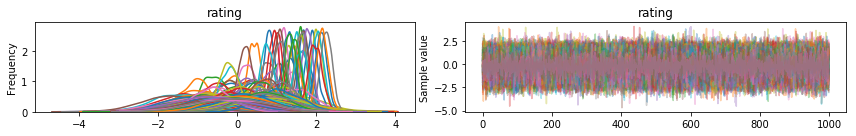

In [8]:
pm.traceplot(trace, varnames=['rating'])

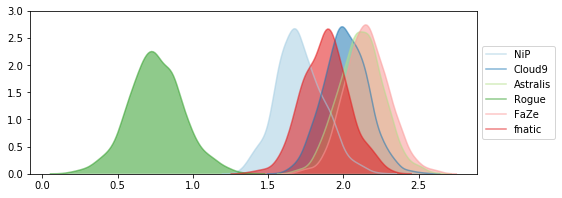

In [12]:
v = {4411: 'NiP', 5752: 'Cloud9', 6665: 'Astralis', 7157: 'Rogue', 6667: 'FaZe', 4991: 'fnatic'}
f, ax = plt.subplots(figsize=(8,3), sharex=True, sharey=True)
sns.set_palette('Paired', len(v))
plt.ylim(0,3.0)
[sns.kdeplot(trace['rating'][:,tmap[i]], shade=True, alpha=0.55, legend=True, ax=ax, label=v) for i,v in v.items()]
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Plot the last period rating for some teams

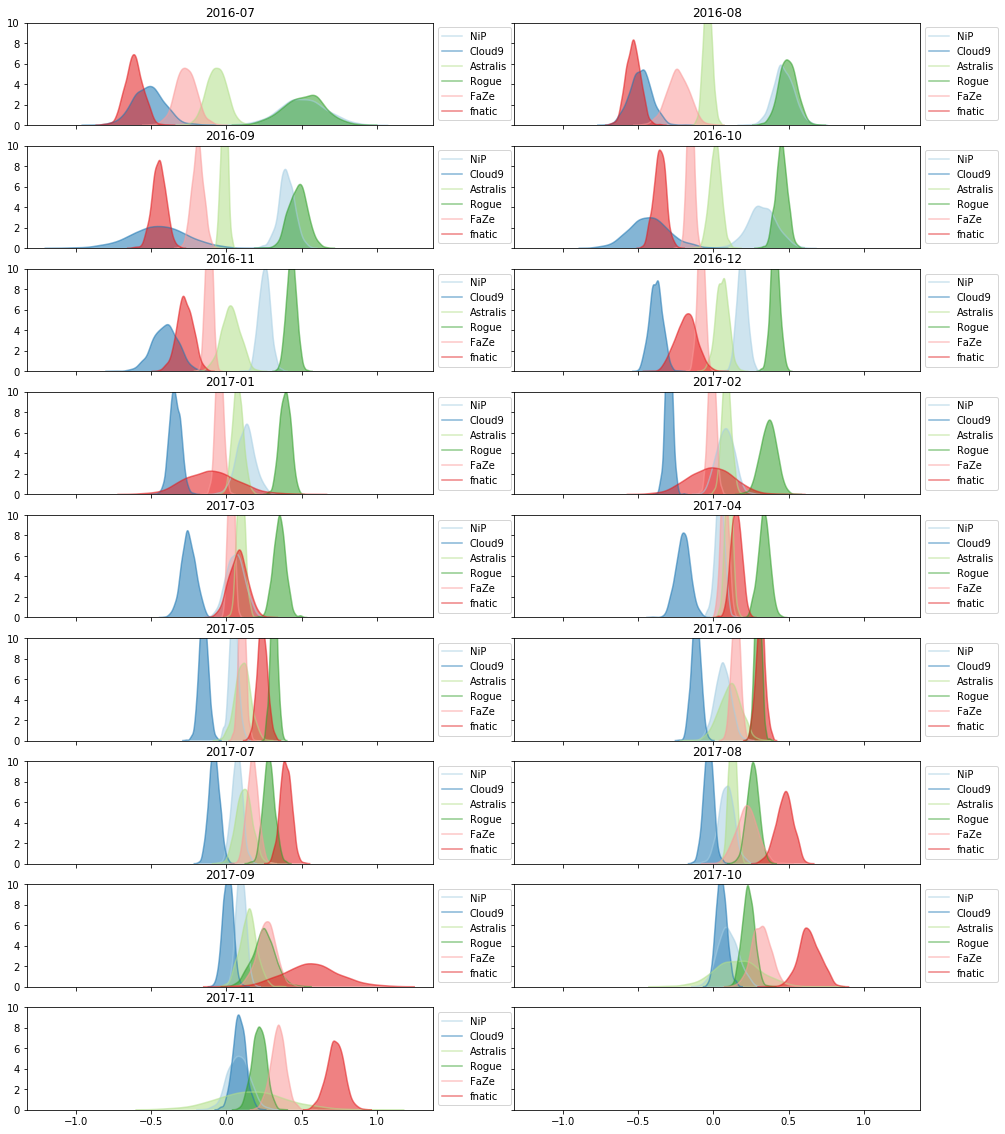

In [24]:
v = {4411: 'NiP', 5752: 'Cloud9', 6665: 'Astralis', 7157: 'Rogue', 6667: 'FaZe', 4991: 'fnatic'}
num_rows = int(np.ceil(n_periods/2))
f, ax = plt.subplots(num_rows, 2, figsize=(16,20), sharex=True, sharey=True)
ax = ax.flatten()
sns.set_palette('Paired', n_teams)
plt.ylim(0,10.0)
for i in np.arange(n_periods):
    ax[i].set_title(periods[i])
    [sns.kdeplot(ap_trace['time_rating'][:,i,tmap[j]], shade=True, alpha=0.55, legend=True, ax=ax[i], label=v) for j,v in v.items()]
    ax[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Plot some over time ratings

C:\Users\kevin.pei\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


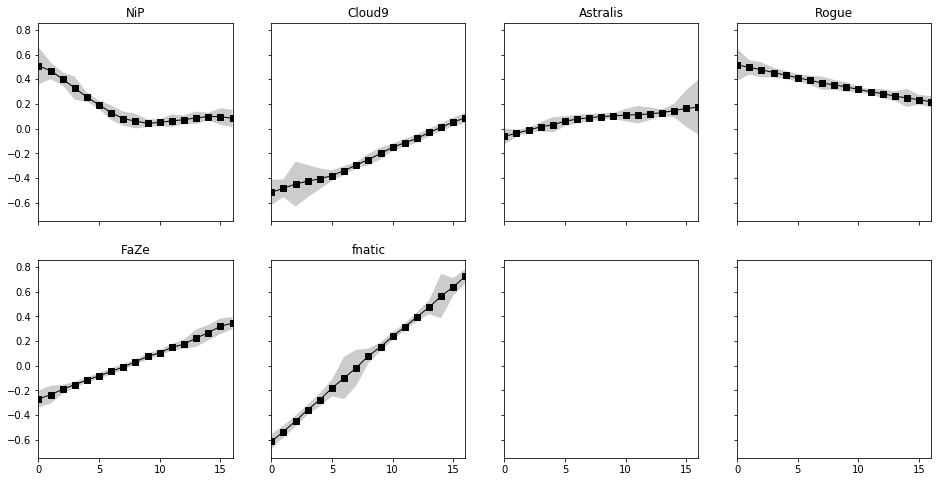

In [20]:
num_rows = int(np.ceil(len(v)/4))
f, ax = plt.subplots(num_rows, 4, figsize=(16,8), sharex=True, sharey=True)
ax = ax.flatten()
condensed_ratings = {j: np.vstack([ap_trace['time_rating'][:,i,tmap[j], ] for i in range(n_periods)]).T for j,n in v.items()}
for i,(j,n) in enumerate(v.items()):
    ax[i].set_title(n)
    sns.tsplot(condensed_ratings[j], color='black', ci='sd', ax=ax[i], marker='s', linewidth=1)